### <span style="color:olive">Data Science Project</span> 
# Training Robust Neural Networks under Adversarial Attacks

$\newcommand{\norm}[1]{\|#1\|}$

Plan:
#### 0) Train a network for CIFAR 10
#### 1) Attack the network : Adversarial example using FGSM
#### 2) Adverserial examples with PGD (Projected Gradient Descent)
#### 3) Black Box attacks (NES)
***

Ce projet a pour but d'illustrer différents types d'attaques adverses contre un réseau de neurones entraîné au préalable. Nous prendrons ici l'example de la reconnaissance d'images sur le jeu de données CIFAR-10 avec un réseau dont l'architecture est imposée.


Dans le cadre de ce projet, nous illustrerons plusieurs types d'attaques adverses non-ciblées, selon que l'on ait accès aux informations du réseau (configuration dite "white-box") ou non (configuration dite "black-box").

Résumons les objectifs du projet:

* Générer des exemples adversariaux grâce aux techniques FGSM et PGD, et observer que les réseaux de neurones sont vulnérables à ces attaques. 
* Reproduire les résultats du papier de Ilyas and al. (2018), c'est-à-dire dans le cadre d'une attaque "black box".

# Part 0 - Train a network for CIFAR 10

In [23]:
import tensorflow.compat.v1 as tf 
tf.enable_eager_execution()
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import plot_model, to_categorical

from random import seed, randint
import numpy as np
from random import randint

# Import data set
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape[0], 'exemples pour l''entrainement')
print(x_test.shape[0], 'exemples pour le test')
print("Shape d'une image :", x_train.shape[1:])

50000 exemples pour lentrainement
10000 exemples pour le test
Shape d'une image : (32, 32, 3)


### **Exploration du training set :**
Quelques exemples d'images issues de CIFAR-10.

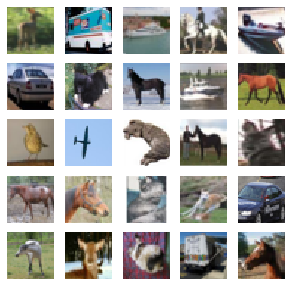

In [24]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Illustrations des images contenues dans le training set 
fig, axes1 = plt.subplots(5,5,figsize=(5,5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train[i:i+1][0])

In [0]:
### Encode the data

# input image dimensions (32 x 32)
img_rows = x_train.shape[1] 
img_cols = x_train.shape[2] 

# 4D tensor with shape : (nb of samples, rows, cols, channels) 
image_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3) # channels = 3 (RGB)
image_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3) # channels = 3 (RGB)

# normalisation of the inputs
image_train = image_train.astype('float32')
image_train = image_train/255.0

image_test = image_test.astype('float32')
image_test = image_test/255.0

# one-hot encoding (3 becomes [0,0,0,1,0,0,0,0,0 0])
num_class = 10
label_train = to_categorical(y_train, num_class)
label_test = to_categorical(y_test, num_class)

### Architecture du réseau de neurones et entraînement

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0   

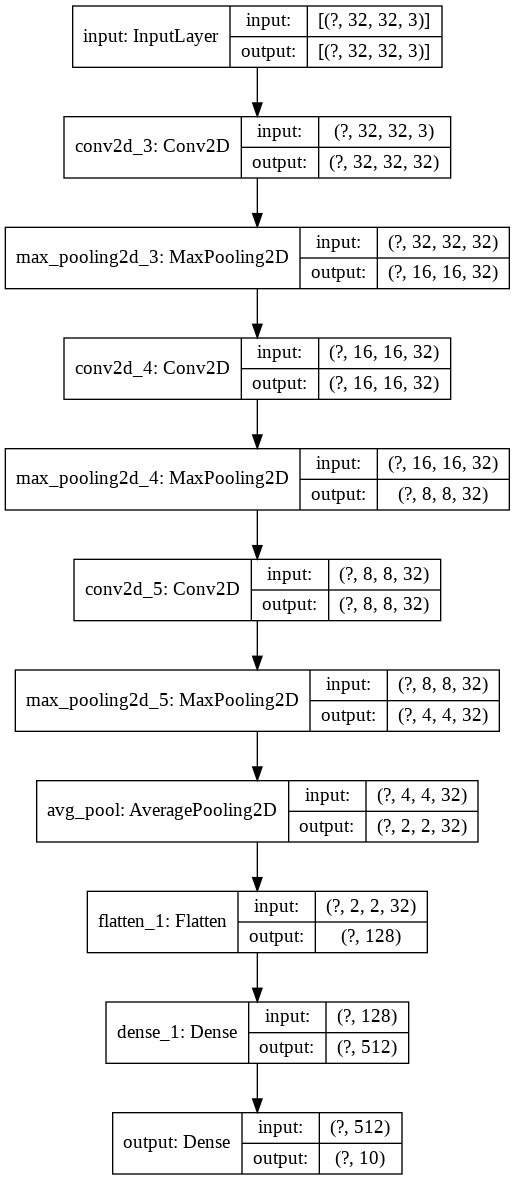

In [26]:
# network architecture : 
def build_model(shape):

    model_input = layers.Input(shape, name='input')
    
    # stage 1 : (Conv+ReLU+MaxPool)x3
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(model_input) 
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x) 
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
 
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x) 
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    
    # stage 2 : AvgPool     
    x = layers.AvgPool2D(pool_size=(2,2), name='avg_pool')(x)
    
    # stage 3 : FC
    x = layers.Flatten(name='flatten_1')(x)
    
    # stage 4 : ReLu activation
    x = layers.Dense(512, activation='relu')(x)
    
    # stage 5 : FC
    output = layers.Dense(num_class, activation='softmax', name='output')(x)

    model = models.Model(inputs=model_input, outputs=output)
    
    return model

input_shape = (img_rows, img_cols, 3)
model = build_model(input_shape) 
model.summary()
plot_model(model, to_file='network_architecture.png', show_shapes=True)

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])     
              #optimizers.RMSprop(lr=0.0001, decay=1e-6)
              
batch_size = 32
epochs = 100

history = model.fit(image_train, label_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2,
          shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 129us/sample - loss: 1.9161 - acc: 0.3017 - val_loss: 1.7247 - val_acc: 0.3699
Epoch 2/100
40000/40000 [==============================] - 5s 117us/sample - loss: 1.6573 - acc: 0.3935 - val_loss: 1.6011 - val_acc: 0.4212
Epoch 3/100
40000/40000 [==============================] - 5s 116us/sample - loss: 1.5559 - acc: 0.4326 - val_loss: 1.5167 - val_acc: 0.4519
Epoch 4/100
40000/40000 [==============================] - 5s 118us/sample - loss: 1.4827 - acc: 0.4595 - val_loss: 1.4640 - val_acc: 0.4735
Epoch 5/100
40000/40000 [==============================] - 5s 120us/sample - loss: 1.4323 - acc: 0.4826 - val_loss: 1.4278 - val_acc: 0.4873
Epoch 6/100
40000/40000 [==============================] - 5s 126us/sample - loss: 1.3935 - acc: 0.4956 - val_loss: 1.3963 - val_acc: 0.5042
Epoch 7/100
40000/40000 [==============================] - 5s 126us/sample - loss: 1.3629 - acc: 0.5072 

In [0]:
### Save a model cell
model.save('CIFAR10_trained.h5')
# Download h5 file if on Colab
from google.colab import files
files.download( "CIFAR10_trained.h5" )

In [0]:
"""### Load a model cell
from tensorflow.keras.models import load_model

# Jupyter Notebook
model = load_model('LM.h5')

# # Google drive for Colab
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd "/content/drive/My Drive/Colab Notebooks/" 
# model = load_model('LM.h5')""";

In [31]:
test_loss, test_acc = model.evaluate(image_test, label_test, verbose=0)
train_loss, train_acc = model.evaluate(image_train, label_train, verbose=0)
print('Model loss :', test_loss)
print('Model accuracy on test set :', round(test_acc*100, 2), "%")
print('Model accuracy on training set : ', round(train_acc*100, 2), "%")

Model loss : 0.858021044254303
Model accuracy on test set : 71.04 %
Model accuracy on training set :  79.99 %


Predicted class : bird
Answer class : bird


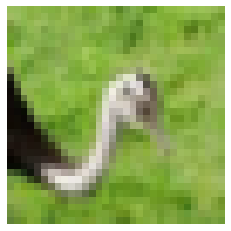

In [34]:
rnd = randint(0,x_test.shape[0]) # random image

plt.imshow(x_test[rnd])
plt.axis("off")
img = image_test[rnd].reshape(1, img_rows, img_cols, 3)
cifar_classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Predicted class :", cifar_classes[np.argmax(model.predict(img))])
print("Answer class :", cifar_classes[y_test[rnd][0]]) 

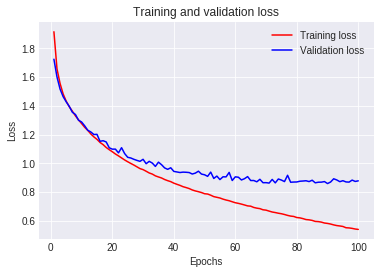

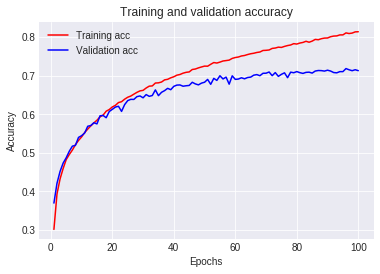

In [35]:
### plot the results

# loss
history_dict = history.history # dict with 4 keys : ['val_loss', 'val_accuracy', 'loss', 'accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
acc = history_dict['acc'] #
val_acc = history_dict['val_acc'] #
plt.plot(epochs, acc, 'r', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend() 
plt.show();

# 1 - Attack the network : Adversarial example using FGSM

On définit les attaques adverses comme des entrées spécifiquement construites dans le but de tromper un réseau de neurones, et donnant lieu à une erreur de classification. Ces exemples adverses doivent rester indiscernables de l'exemple original par l'oeil humain mais empêcher le réseau de neurones de correctement en identifier la sémantique. Il y a plusieurs types d'attaque de réseaux. Nous nous intéressons plus particulièrement ici à l'attaque "Fast Gradient Sign Method (FGSM)", une attaque très populaire de type "white-box". Une attaque de type "white-box" est une attaque où l'attaqueur a un accès complet au modèle et ses informations (notamment le gradient).

[Goodfellow and al. (2015)]

### Principe d'une attaque adverse
Comment pouvons-nous modifier une image en entrée pour tromper notre classifieur afin qu'il la classifie dans la mauvaise catégorie d'image ?

Pour répondre à cette question, rappelons que l'approche commune pour entraîner un classifieur est d'optimiser les paramètres $\theta$ pour minimiser un coût total sur un ensemble de données d'entraînement $\{x_i, y_i\}_{i=1}^{m}$
ce qui s'écrit comme le problème d'optimisation suivant:
$$\min_{\theta}\frac{1}{m}\sum_{i=1}^{m}l(h_{\theta}(x_i),y_i)$$
On résout ce problème typiquement par le biais d'une approche descente de gradient (stochastique), i.e. pour un minibatch $\mathcal{B} \subseteq \{1, \dots, m\}$, on calcule le gradient de la fonction de coût selon $\theta$ et on réalise un ajustement de $\theta$ dans la direction négative du gradient pour minimiser la fonction de coût. Pour chaque itération t :

$$\theta_{t+1} = \theta_t - \alpha\sum_{i \in \mathcal{B}}\nabla_{\theta_t}l(h_{\theta_t}(x_i),y_i)$$

On répète ce processus pour différents minibatches qui couvrent la totalité du jeu de données jusqu'à convergence.

Le terme auquel on s'intéresse tout particulièrement ici est le gradient $\nabla_{\theta}l(h_{\theta}(x_i),y_i)$, qui indique combien un petit ajustement aux paramètres $\theta$ impacte la fonction de coût. 

Mais le principe des réseaux de neurones nous autorise tout aussi bien à calculer le gradient de la fonction de coût par rapport à une entrée $x_i$. Cette quantité nous indiquera donc combien un petit changement de l'image elle-même pourra affecter la fonction de coût.

C'est de cette manière que nous pouvons concevoir une attaque adverse. Cette fois, au lieu d'ajuster les paramètres $\theta$ pour minimiser l'erreur, nous allons ajuster l'image elle-même pour maximiser l'erreur. Il s'agit donc de résoudre le problème suivant:

$$\max_{\hat{x}}l(h_{\theta}(\hat{x}),y)$$

où $\hat{x}$ indique un exemple adverse qui tente de maximiser l'erreur. Évidemment, il ne s'agit pas de maximiser de façon arbitraire (on ne veut pas transformer complètement une image d'entrée en quelque chose de complètement différent, auquel cas il n'y aura rien d'étonnant à ce que la classifieur change sa prédiction). Il s'agit en fait de s'assurer que $\hat{x}$ reste "près" de l'entrée de départ $x$. Par convention, on va plutôt opimiser sur la perturbation que l'on apporte à $x$, notée $\delta$ i.e. 

$$\max_{\delta \in \Delta}l(h_{\theta}(x + \delta),y)$$

On indique ici par $\Delta$ l'ensemble des perturbations autorisées. Caractériser l'ensemble des perturbations autorisées est un problème difficile. En théorie, on veut que $\Delta$ puisse capture tout ce que des humains considèrent comme "semblable" à l'entrée de départ $x$. Cela peut inclure aussi bien ajouter un léger "bruit", des rotations, translations etc tout en maintenant la sémantique originale. 

Un choix usuel est la boule $l^{\infty}$ que l'on définit par l'ensemble $\Delta =\{\delta\text{ s.t. }\norm{\delta}\leq\epsilon\}$ où on définit la norme infinie d'un vecteur quelconque par $\norm{z}^{\infty}=\max_{i}|z_i|$.
L'ensemble choisi indique donc que l'on autorise des perturbations d'ordre de grandeur $[-\epsilon, \epsilon]$ pour chacune des composantes. L'idée d'utilser la boule $l^{\infty}$ est que pour des petites valeurs $\epsilon$, on crée des perturbations qui ajoutent pixel par pixel des composantes tellement petites qu'elles sont indistinguables de l'exemple original.

### Principe de l'attaque FGSM

De quelle manière peut-on résoudre le problème suivant? $$\max_{\delta \leq \norm{\epsilon}}(l(h_{\theta}(x + \delta),y))$$

L'idée élémentaire est la suivante: avec la backpropagation, on calcule le gradient de la fonction de coût en fonction de la parturbation $\delta$. 


Pour un exemple d'entrée $x$, nous allons ajuster $\delta$ dans la direction du gradient i.e. nous allons d'abord calculer le gradient suvaint $$u = \nabla_{\delta}l(h_{\theta}(x+\delta),y)$$ par simple backpropagation. Pour maximiser la perte, nous voulons ajuster $\delta$ dans la direction du gradient, i.e., réaliser le changement suivant $$\delta = \delta + \alpha u$$ pour un certain pas $\alpha$. Il nous faudra ensuite reprojeter sur la boule définie par $\norm{\delta} \leq \epsilon$. 

Quel pas pouvons-nous nous autoriser? Si l'on considère l'exemple de la boule $l^{\infty}$, il nous faudra "clipper" les valeurs de $\delta$ pour conserver $\delta$ dans l'intervalle $[-\epsilon, \epsilon]$. Si par exemple le $\delta$ initial est de zéro, la modification de $\delta$ correspondra à 
$\delta=\text{clip(}\alpha u,[−\epsilon,\epsilon])$.

Intuitivement, on comprend que les composantes de $u$ ne sont pas importantes pour $\alpha$ suffisamment grand, i.e. pour un $\alpha$ grand, la modification de $\delta$ devient:
$$\delta = \epsilon\text{sign}(u)$$

C'est la méthode FGSM.

In [0]:
# Create FGSM adversarial pattern 
def fgsmPattern(image, label, epsilon):
    image = tf.cast(image, tf.float32) # tensor conversion
    
    with tf.GradientTape() as tape: 
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image) # gradient of the loss according to the input x

    signed_grad = tf.sign(gradient) # signe du gradient
    
    image = image + epsilon*signed_grad
    image = image.numpy()
    
    return image

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class under attack : dog 
with confidence : 57.76 %

Truth class : horse


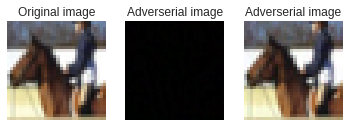

In [37]:
# Try on some example
epsilon = 0.01
rnd = randint(0,x_train.shape[0])

x_adv = fgsmPattern(image_train[rnd].reshape((1,img_rows, img_cols, 3)), label_train[rnd], epsilon)
x_adv = np.clip(x_adv, 0, 255) # ensure valid pixel range

print("Predicted class under attack :", cifar_classes[np.argmax(model.predict(x_adv))], "\nwith confidence :", round(np.max(model.predict(x_adv))*100, 2), "%\n")
print("Truth class :", cifar_classes[y_train[rnd][0]])

plt.subplot(1,3,1)
plt.imshow(image_train[rnd])
plt.title("Original image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(x_adv[0]-image_train[rnd])
plt.title("Adverserial image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(x_adv[0])
plt.title("Adverserial image")
plt.axis("off")
plt.show();

In [38]:
esp_vec = np.logspace(-6,-0.6,10)
x_advs = np.zeros(image_test.shape)
test_loss_fgsm = np.zeros(len(esp_vec))
test_acc_fgsm = np.zeros(len(esp_vec))

for j in range(len(esp_vec)):
    print(j, "/", len(esp_vec))
    for i in range(int(x_test.shape[0]/2)):
        x_advs[i] = fgsmPattern(image_test[i].reshape(1,img_rows, img_cols, 3), label_test[i], esp_vec[j])

    test_loss_fgsm[j], test_acc_fgsm[j] = model.evaluate(x_advs, label_test, verbose=0)

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


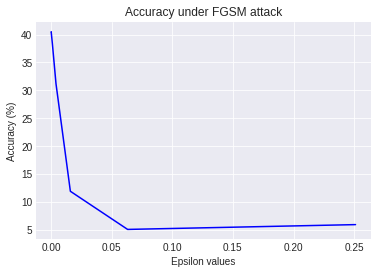

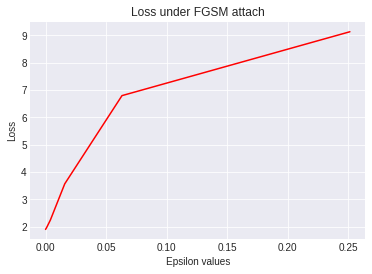

In [39]:
plt.plot(esp_vec, test_acc_fgsm*100, 'b',)
plt.title('Accuracy under FGSM attack') 
plt.xlabel('Epsilon values')
plt.ylabel('Accuracy (%)') 
plt.show()
plt.plot(esp_vec, test_loss_fgsm, 'r') 
plt.title('Loss under FGSM attach') 
plt.xlabel('Epsilon values')
plt.ylabel('Loss') 
plt.show();

In [91]:
nb_ex = 500
error = 0

for i in range(nb_ex):
    x_adv = fgsmPattern(image_test[i].reshape((1,img_rows, img_cols, 3)), label_test[i], epsilon)
    x_adv = np.clip(x_adv, 0, 255) # ensure valid pixel range

    if np.argmax(model.predict(x_adv)) != y_test[i][0]:
        error += 1

error /= nb_ex

print('Error rate of the model under FGSM attack (over all test exemples) :', round(error*100, 2), "%")

Error rate of the model under FGSM attack (over all test exemples) : 99.6 %


In [0]:
# Utility function to plot images on a grid
def plot_images(X, y, yp, M, N):
    '''Plot a selection of images in a grid'''
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N*2,M*2))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j])
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j]))
            plt.setp(title, color=('g' if yp[i*N+j] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

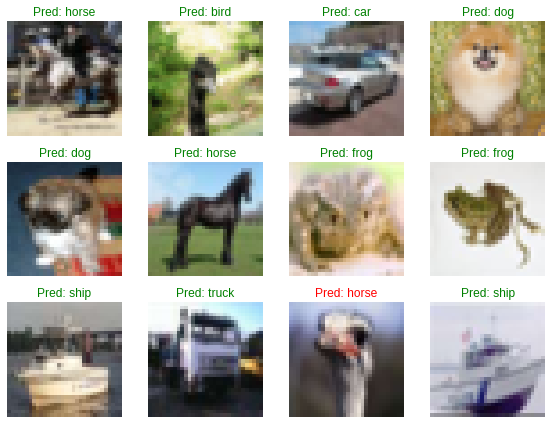

In [41]:
# Illustrate original predictions
idxImages = [754, 35645, 16853, 45417, 7776, 22036, 15816, 21047, 216, 10198, 11313, 4897]
X = image_train[idxImages].astype(np.float32)
y = label_train[idxImages]
yp = model(X).numpy()
yp_labels = np.array(cifar_classes)[yp.argmax(axis=1).astype(int)]
y_labels = np.array(cifar_classes)[y.argmax(axis=1).astype(int)]
plot_images(X,y_labels,yp_labels, 3, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


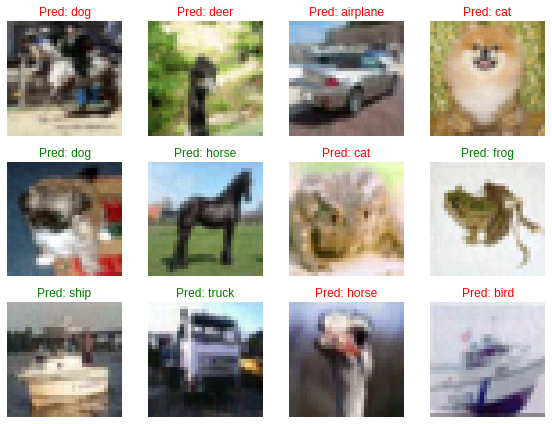

In [42]:
# Illustrate images under attack
# Illustrate attacked images
X = fgsmPattern(image_train[idxImages].reshape((-1, img_rows, img_cols, 3)), y,0.01)
yp = model(X).numpy()
yp_labels = np.array(cifar_classes)[yp.argmax(axis=1).astype(int)]
plot_images(X,y_labels,yp_labels, 3, 4);

FGSM démontre que des réseaux de neurones profonds sont vulnérables à des attaques adverses simples où l'entrée originale est modifiée de façon inifinitésimale mais entraîne néanmoins une erreur de classification.

# 2 - Adverserial examples with PGD (Projected Gradient Descent)

Cette attaque, aussi appelée I-FGSM pour Iterative-FGSM, n'est rien d'autre que FGSM inclue dans une méthode de descente de gradient projetée. 
Dans cette partie et le reste de l'étude, la norme infinie sera considérée pour la projection.

Rappelons que l'attaque FGSM repose sur une forte hypothèse, à avoir on suppose que l'approximation linéaire de notre réseau de neurones donnée par le gradient en un certain point $x$ est une approximation raisonablement valable sur tout l'ensemble $\norm{\delta}_{\infty} \leq \epsilon$. Ceci indique immédiatement le problème de FGSM puisqu'un réseau de neurones est spécifiqement utilisé pour des problèmes non linéaires et donc que le classifieur résultant de notre réseau de neurones n'est probablement pas linéaire, même sur une petite région. Il nous faut donc considérer une meilleur méthode qu'une seut itération de la projection pour augmenter l'erreur.

### Principe du PGD

L'algorithme élementaire consiste en répeter:
$$\delta = \Pi_{[-\epsilon, \epsilon]}(\delta + \alpha \nabla_\delta l(h_\theta(x + \delta),y))$$

où $\Pi_{[-\epsilon, \epsilon]}$ dénote la projection sur la boule $l^{\infty}$

Nous avons donc maintenant à faire des choix supplémentaires dans la spécification de l'attaque comme par exemple le nombre d'itérations. 

In [0]:
def projection(sample, norm, epsilon):

    # Clipping perturbation sample to norm ball
    if norm not in [np.inf, 1, 2]:
        raise ValueError('ord must be np.inf, 1, or 2.')

    if norm == np.inf:
        sample = np.clip(sample, -epsilon, epsilon)

    return sample

In [0]:
# PGD function
def ProjectedGradientDescent(model, niter, x_adv, label, epsilon): 
    cost = np.zeros(niter)
    x = x_adv

    for t in range(niter): 
        cost[t] = tf.keras.losses.categorical_crossentropy(label, model(tf.cast(x_adv, tf.float32)))
        x_adv = fgsmPattern(x_adv, label, epsilon)

        perturb = x_adv - x
        perturb = projection(perturb, np.inf, epsilon)
        x_adv = x + perturb

        x_adv = np.clip(x_adv, 0, 255) # ensure it's in the good range
    print("PGD done...")
    return (x_adv, cost)

Illustration de PGD sur une image sélectionnée aléatoirement et attaquée 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD done...
Predicted class under attack : airplane 
with confidence : 98.97 %

Truth class : ship


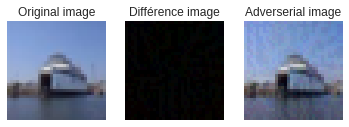

In [45]:
niter = 15
epsilon = 0.025

rnd = randint(0,image_test.shape[0])

x = image_test[rnd].reshape(1, img_rows, img_cols, 3)
x = np.clip(x, 0, 255) # ensure valid pixel range
y = label_test[rnd]

x_PGD, cost_PGD = ProjectedGradientDescent(model, niter, x, y, epsilon)

print("Predicted class under attack :", cifar_classes[np.argmax(model.predict(x_PGD))], "\nwith confidence :", round(np.max(model.predict(x_PGD))*100, 2), "%\n")
print("Truth class :", cifar_classes[y_test[rnd][0]])

plt.subplot(1,3,1)
plt.imshow(x[0])
plt.title("Original image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(x_PGD[0]-x[0])
plt.title("Différence image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(x_PGD[0])
plt.title("Adverserial image")
plt.axis("off")
plt.show();

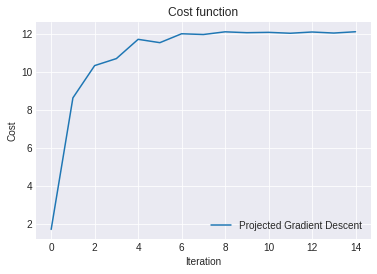

In [46]:
plt.plot(range(niter), cost_PGD, label="Projected Gradient Descent")
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show();

La loss augmente avec le nombre d'itération de PGD. C'est logique, au fur et à mesure des itérations, l'image perturbée trompe de mieux en mieux le réseau jusqu'à atteindre un palier au bout de quelques itérations où la loss est maximisée pour la perturbation envisagée. 

In [0]:
# PGD function with loop on all examples to compute the accuracy of the attack
def ProjectedGradientDescentAll(model, niter, epsilon, image_test, y_test): 
    x_advs = np.zeros((300, img_rows, img_cols, 3))
    true_label = np.zeros(300)
    cost = np.zeros((niter))
    global_cost = np.zeros((niter))

    for i in range(300): 
        if i%5==0:
            print(i+1, "/", 300)
        rand_ind = np.random.randint(0, image_test.shape[0])
        x_adv = image_test[rand_ind].reshape(1, img_rows, img_cols, 3)
        label = label_test[rand_ind]
        true_label[i] = y_test[rand_ind]

        for t in range(niter): 
            cost[t] = tf.keras.losses.categorical_crossentropy(label, model(tf.cast(x_adv, tf.float32)))
            x_adv = fgsmPattern(x_adv, label, epsilon)

            perturb = x_adv - x
            perturb = projection(perturb, np.inf, epsilon)
            x_adv = x + perturb

            x_adv = np.clip(x_adv, 0, 255) # ensure it's in the good range
            global_cost += cost

    x_advs[i] = x_adv

    global_cost /= 300 
    print("PGD with loop done...")
    
    return (x_advs, true_label, global_cost)

In [85]:
niter = 15
epsilon = 0.05

x_PGD, y_PGD, cost_PGD = ProjectedGradientDescentAll(model, niter, epsilon, image_test, y_test) 

1 / 300
6 / 300
11 / 300
16 / 300
21 / 300
26 / 300
31 / 300
36 / 300
41 / 300
46 / 300
51 / 300
56 / 300
61 / 300
66 / 300
71 / 300
76 / 300
81 / 300
86 / 300
91 / 300
96 / 300
101 / 300
106 / 300
111 / 300
116 / 300
121 / 300
126 / 300
131 / 300
136 / 300
141 / 300
146 / 300
151 / 300
156 / 300
161 / 300
166 / 300
171 / 300
176 / 300
181 / 300
186 / 300
191 / 300
196 / 300
201 / 300
206 / 300
211 / 300
216 / 300
221 / 300
226 / 300
231 / 300
236 / 300
241 / 300
246 / 300
251 / 300
256 / 300
261 / 300
266 / 300
271 / 300
276 / 300
281 / 300
286 / 300
291 / 300
296 / 300
PGD with loop done...


PDG loss = 3.051496868133545
PDG accuracy = 7.999999821186066 %


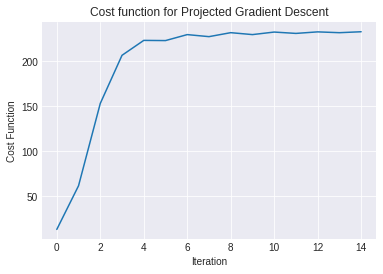

In [86]:
test_loss_pgd, test_acc_pgd = model.evaluate(x_PGD, to_categorical(y_PGD, num_class), verbose=0)
print("PDG loss =", test_loss_pgd)
print("PDG accuracy =", test_acc_pgd*100, "%")

plt.plot(range(niter), cost_PGD)
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function for Projected Gradient Descent")
plt.show();

Ci-dessus la loss moyenne sur 300 exemples pris au hasard dans le test set. 

Le taux d'erreur du réseau sur une image perturbée est très élevé. L'accuracy résultante après notre attaque tend donc vers qq %. On en conclue que ce type d'attaque "white box" du 1er ordre itérée est très efficace contre les réseaux.

PGD done...
PGD done...
PGD done...
PGD done...
PGD done...
PGD done...
PGD done...
PGD done...
PGD done...
PGD done...
PGD done...
PGD done...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


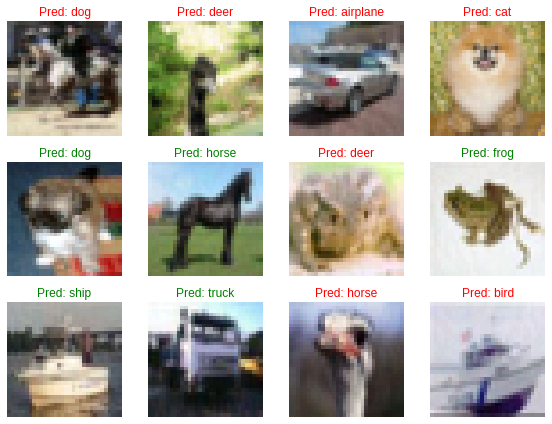

In [54]:
# Illustrate images under attack
nIter = 200
X = []
y = label_train[idxImages]
for i in range(len(idxImages)):
    A, _ = ProjectedGradientDescent(model, nIter, image_train[idxImages[i]].reshape((-1, img_rows, img_cols, 3)), y[i], 0.01)
    A = A.reshape((32, 32, 3))
    X.append(A)
X = np.asarray(X)
yp = model(X).numpy()
yp_labels = np.array(cifar_classes)[yp.argmax(axis=1).astype(int)]
plot_images(X,y_labels,yp_labels, 3, 4)

Pour se donner quelques cas concrets sur la performance de I-FGDM, voici quelques images de test. L'attaque PGD se révèle notamment plus performante que FGSM pour l'image ship (dernière ligne, deuxième colonne)

# 3 - Black Box attacks

Nous quittons à présent l'étude des attaques de réseaux dits "white box" (où on a accès au gradient). Nous nous plaçons alors dans un cadre plus "réaliste" où l'accès aux informations du réseau est limité (ni accès aux poids, ni au gradient) : on parle de configuration "Black Box". 

Nous pouvons simplement envoyer une image au réseau et obtenir sa prédiction. Nous allons voir que ces simples requêtes nous suffisent à approximer le gradient. De plus, la plupart des systèmes réels limitent le nombre de requête ou les rendent payantes. Il faut donc réussir à trouver une approximation du gradient avec le miminum de requêtes possible.

La stratégie utilisée est fondée sur les "Natural Evolutionary Strategies" ou NES. Nous allons détailler la méthode dans la prochaine sous-partie.

["Black-box Adversarial Attacks with Limited Queries and Information" de Ilyas and al. (2018)]

## Configuration black box : Approximation du gradient (NES)

In [0]:
# fonction type white box pour faire le vrai calcul du grad (utilisé par la suite comme référence)

def real_grad(model, image, label):
    # Returns gradient directly from the neural network
    image = tf.cast(image, tf.float32)
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)

    return tape.gradient(loss, image)

Ci-dessous la fonction NES pour le calcul du gradient :
* Sélection aléatoire d'une image
* Perturbation gaussienne de chaque pixel
* Requête sur le réseau de l'image perturbée = prédiction du réseau
* Calcul de la loss entre la classe de la prédiction et la classe de l'image non-perturbée
* Calcul du gradient comme une simple dérivée. Les perturbations ayant engendré une loss élevée (mauvaise classification) sont valorisées. 

Cette procédure est effectuée 50 fois (hyper paramètre suggéré dans l'article d'Ilyas and al.) pour effectuer une moyenne. 

In [0]:
# fonction NES pour approx du gradient

def NES(model, image, label, sigma, n):
    # Returns estimate of the gradient using NES approach
    img_rows, img_cols, channels = 32, 32, 3
    N = img_rows * img_cols * channels
    x = image.reshape(N)
    gradient = np.zeros((1, img_rows, img_cols, channels))
    cce = tf.keras.losses.CategoricalCrossentropy()

    for i in range(n):
        
        delta_i = np.random.normal(0,1,N)
        theta_pos = x + sigma * delta_i
        theta_neg = x - sigma * delta_i

        theta_pos = theta_pos.reshape((1, img_rows, img_cols, channels))
        theta_neg = theta_neg.reshape((1, img_rows, img_cols, channels))

        prediction_pos = model.predict(theta_pos)
        prediction_neg = model.predict(theta_neg)
  
        loss_pos = - cce(label, prediction_pos)
        loss_neg = - cce(label, prediction_neg)

        gradient += loss_pos * delta_i.reshape((1, img_rows, img_cols, channels))
        gradient -= loss_neg * delta_i.reshape((1, img_rows, img_cols, channels))
    
    gradient /= 2*n*sigma
  
    return gradient

Illustration de l'approximation du gradient sur une image précise :

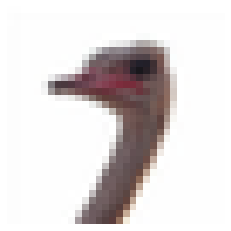

In [57]:
# Image originale
ind = 4418
image = image_train[ind]
label = label_train[ind]
plt.axis('off')
plt.imshow(image);

In [0]:
true_grad = real_grad(model, image_train[ind].reshape((-1, 32, 32, 3)), label_train[ind])
true_grad = true_grad.numpy().reshape(32, 32, 3)
sigma = 0.001
n = 5000 # on pousse le nombre d'itération pour estimation plus subtilement le gradient pour cet exemple
est_grad = NES(model, image, label, sigma, n)


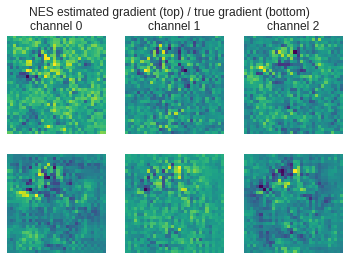

In [69]:
# Illustrate estimation of gradient.
est_grad = est_grad.numpy().reshape(32,32,3)
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.suptitle("NES estimated gradient (top) / true gradient (bottom)")
for ch in range(3):
    ax[0, ch].imshow(est_grad[:,:,ch], cmap='viridis')
    ax[0, ch].set_title(f"channel {ch}")
    ax[0, ch].set_axis_off()
    ax[1, ch].imshow(true_grad[:,:,ch], cmap='viridis')
    ax[1, ch].set_axis_off()

L'approximation du gradient ne permet pas de reproduire le vrai gradient parfaitement. 
Dans la suite, nous allons montrer que ce n'est pas important dès lors que ce qui nous intéresse est le signe du gradient. Ce qui nous sauve également est le fait de pouvoir itérer plusieurs fois en utilisant PGD. 

## Configration black box : PGD 

In [0]:
# PGD Black box function with norm inf projection
def PGDBlackBox(niter, image, label, eta, epsilon, sigma, n): 
    cost = np.zeros(niter)
    x0 = image
    x_adv = image

    for t in range(niter): 
        cost[t] = tf.keras.losses.categorical_crossentropy(label, model(tf.cast(x_adv.reshape(1, img_rows, img_cols, 3), tf.float32)))
       
        GradEstim = NES(model, x_adv, label, sigma, n)
        signed_grad = tf.sign(GradEstim)
        x_adv = x_adv - eta*signed_grad

        perturb = x_adv - x0
        perturb = projection(perturb, np.inf, epsilon)
        x_adv = x0 + perturb

        x_adv = np.clip(x_adv, 0, 255) # ensure it's in the good range
    print("PGD Black Box done...")
    return (x_adv, cost)

Lancement de la procédure black box (calcul gradient NES et itération avec PGD) sur un exemple sélectionné aléatoirement

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD Black Box done...
Predicted class under attack : airplane 
with confidence : 86.03 %

Truth class : bird


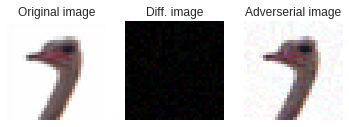

In [65]:
# hyper paramètres
niter = 30
eta = 0.01
epsilon = 0.05
sigma = 0.01
n = 50

rnd = 4418 #np.random.randint(0,image_train.shape[0])
image = image_train[rnd]
label = label_train[rnd]

x_PGD, cost_PGD = PGDBlackBox(niter, image, label, eta, epsilon, sigma, n)

print("Predicted class under attack :", cifar_classes[np.argmax(model.predict(x_PGD))], "\nwith confidence :", round(np.max(model.predict(x_PGD))*100, 2), "%\n")
print("Truth class :", cifar_classes[y_train[rnd][0]])

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(x_PGD[0]-image)
plt.title("Diff. image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(x_PGD[0])
plt.title("Adverserial image")
plt.axis("off")
plt.show();

Voici l'attaque black box réussie sur l'exemple pris de l'oiseau. 

On arrive à tromper le réseau en effectuant simplement des requêtes, c'est-à-dire sans jamais avoir eu accès à ses poids, ni à son gradient.

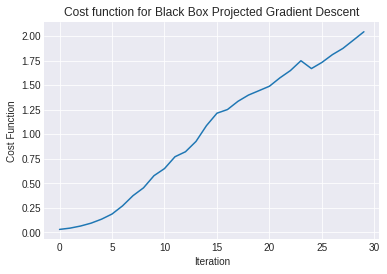

In [67]:
# plot cost function 
plt.plot(range(niter), cost_PGD)
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function for Black Box Projected Gradient Descent")
plt.show();